
=== INPUT PARAMETERS (Simulation) ===
Total flux: 2500000.00 ADU ± 1056.68
Trail length: 2048 px = 540.06 arcsec
PSF FWHM: 0.90 arcsec
PSF FWHMM (pix): 3.41 pix
Sky level: 3800.00 ADU/arcsec² → 264.24 ADU/pixel
Surface brightness: 5143.48 ± 2.17 ADU/arcsec²


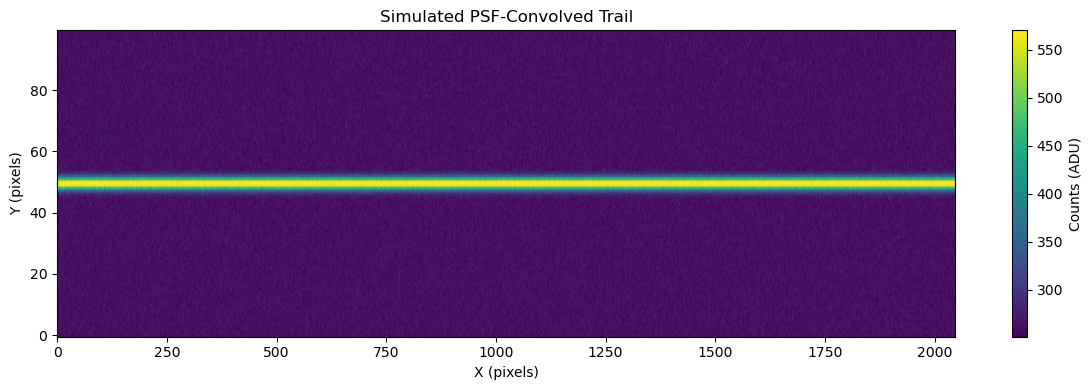

In [18]:
import numpy as np
import galsim
import matplotlib.pyplot as plt

# === Configuration ===
image_size = (100, 2048)
pixel_scale = 0.2637              # arcsec/pixel
trail_length_pix = image_size[1]
trail_width_pix = 1
trail_angle_deg = 0
psf_fwhm_arcsec = 0.9
total_flux = 2.5e6              # ADU

# Background
sky_level_arcsec2 = 3800
background_per_pixel = sky_level_arcsec2 * pixel_scale**2  # ADU/pixel

# Detector
gain = 3.95                     # e-/ADU
read_noise = 6                # e-
rng = galsim.BaseDeviate(42)

# Trail geometry in arcsec
trail_length_arcsec = trail_length_pix * pixel_scale
trail_width_arcsec = trail_width_pix * pixel_scale

# Build trail and PSF
trail = galsim.Box(trail_length_arcsec, trail_width_arcsec).withFlux(total_flux)
trail = trail.rotate(trail_angle_deg * galsim.degrees)
psf = galsim.Gaussian(fwhm=psf_fwhm_arcsec)
obj = galsim.Convolve([trail, psf])

# Draw image
image = galsim.ImageF(image_size[1], image_size[0], scale=pixel_scale)
obj.drawImage(image=image, method='auto')

# Add constant background
image += background_per_pixel

# Add read noise (Poisson noise assumed present in trail flux only)
image.addNoise(galsim.CCDNoise(rng, gain=gain, read_noise=read_noise))

# Save to text file
simulated_image = image.array
np.savetxt("simulated_psf_convolved_trail.txt", simulated_image)

# === Estimate error on total flux and SB
trail_area_arcsec2 = trail_length_arcsec * psf_fwhm_arcsec
sb_arcsec2 = total_flux / trail_area_arcsec2

trail_area_pixels = int(trail_length_pix * psf_fwhm_arcsec / pixel_scale)
signal_e = gain * total_flux
background_e = gain * background_per_pixel * trail_area_pixels
noise_e = np.sqrt(signal_e + background_e + trail_area_pixels * read_noise**2)
flux_err = noise_e / gain
sb_err = flux_err / trail_area_arcsec2

# === Output
print("\n=== INPUT PARAMETERS (Simulation) ===")
print(f"Total flux: {total_flux:.2f} ADU ± {flux_err:.2f}")
print(f"Trail length: {trail_length_pix} px = {trail_length_arcsec:.2f} arcsec")
print(f"PSF FWHM: {psf_fwhm_arcsec:.2f} arcsec")
print(f"PSF FWHMM (pix): {psf_fwhm_arcsec/pixel_scale:.2f} pix")
print(f"Sky level: {sky_level_arcsec2:.2f} ADU/arcsec² → {background_per_pixel:.2f} ADU/pixel")
print(f"Surface brightness: {sb_arcsec2:.2f} ± {sb_err:.2f} ADU/arcsec²")

# === Plot
plt.figure(figsize=(12, 4))
plt.imshow(simulated_image, origin='lower', cmap='viridis', aspect='auto',
           vmin=np.percentile(simulated_image, 5),
           vmax=np.percentile(simulated_image, 99))
plt.title("Simulated PSF-Convolved Trail")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.colorbar(label='Counts (ADU)')
plt.tight_layout()
plt.show()



In [8]:
galsim.Box?

Init signature: galsim.Box(width, height, flux=1.0, gsparams=None)
Docstring:     
A class describing a box profile.  This is just a 2D top-hat function, where the
width and height are allowed to be different.

Parameters:
    width:          The width of the Box.
    height:         The height of the Box.
    flux:           The flux (in photons/cm^2/s) of the profile. [default: 1]
    gsparams:       An optional `GSParams` argument. [default: None]
File:           /opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/galsim/box.py
Type:           type
Subclasses:     Pixel

In [10]:
galsim.CCDNoise?

Init signature: galsim.CCDNoise(rng=None, sky_level=0.0, gain=1.0, read_noise=0.0)
Docstring:     
Class implementing a basic CCD noise model.

The CCDNoise class encapsulates the noise model of a normal CCD image.  The noise has two
components: first, Poisson noise corresponding to the number of electrons in each pixel
(including an optional extra sky level); second, Gaussian read noise.

Note that if the image to which you are adding noise already has a sky level on it,
then you should not provide the sky level here as well.  The sky level here corresponds
to a level is taken to be already subtracted from the image, but which was present
for the Poisson noise.

The units here are slightly confusing.  We try to match the most common way that each of
these quantities is usually reported.  Note: ADU stands for Analog/Digital Units; they are the
units of the numbers in the final image.  Some places use the term "counts" for this.

- sky_level is normally measured from the image itself, s